In [1]:
# import all relevant libraries here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

import wfdb
from wfdb import processing


# assign the correct path to downloaded data and filenames
# realpath is this script path, while data is subfolder in the same dir
# parent_dir =  os.path.dirname(os.path.realpath(__file__))

parent_dir = os.path.abspath('')
data_dir =  os.path.join(parent_dir,'data')


filenames = []

for i in range(10):
    filenames.append('infant'+str(i+1))

# print and list all relevant filenames, as a quick check
print(parent_dir)
print(data_dir)
print(filenames)

def describe_df(df):
    desc = df.describe()
    desc.loc['count'] = desc.loc['count'].astype(int).astype(str)
    desc.loc['nunique'] = df.nunique()
    desc.loc['count_na'] = df.isna().sum()
    desc.iloc[1:] = desc.iloc[1:].applymap('{:.6f}'.format)
    print(desc)


d:\Github\ecg_resp
d:\Github\ecg_resp\data
['infant1', 'infant2', 'infant3', 'infant4', 'infant5', 'infant6', 'infant7', 'infant8', 'infant9', 'infant10']


In [11]:
df_csv = pd.DataFrame()

# if windows
if os.name == 'nt':
    df_csv = pd.read_csv(data_dir+'\processed\subsampled{postfix}.csv'.format(postfix='_'+filenames[2]))
else:
    df_csv = pd.read_csv(data_dir+'/processed/subsampled{postfix}.csv'.format(postfix='_'+filenames[2]))

# filter data both rows & columns
df = df_csv[20000:100000].copy()
df = df[['hrs', 'resp']]

# add time from index
df['time'] = df.index

# remove outliers
min_hrs = df['hrs'].mean()-3*df['hrs'].std()
max_hrs = df['hrs'].mean()+3*df['hrs'].std()

df = df[(df['hrs']>min_hrs)&(df['hrs']<max_hrs)]

# add unique id everytime hrs change
df['id'] = (df[['hrs']].diff() != 0).cumsum()

# print descriptions of the df
describe_df(df)


                 hrs         resp          time           id
count          79574        79574         79574        79574
mean      117.658771    22.188921  60001.644268  1379.724370
std         4.652027     1.011630  23112.707828   792.265012
min       101.351350    15.739890  20000.000000     1.000000
25%       114.503815    21.615650  39893.250000   698.000000
50%       117.187500    22.086799  60061.500000  1376.000000
75%       120.481926    22.778517  80003.750000  2058.000000
max       133.928570    27.476752  99999.000000  2759.000000
nunique    69.000000  2902.000000  79574.000000  2759.000000
count_na    0.000000     0.000000      0.000000     0.000000


<AxesSubplot:ylabel='resp'>

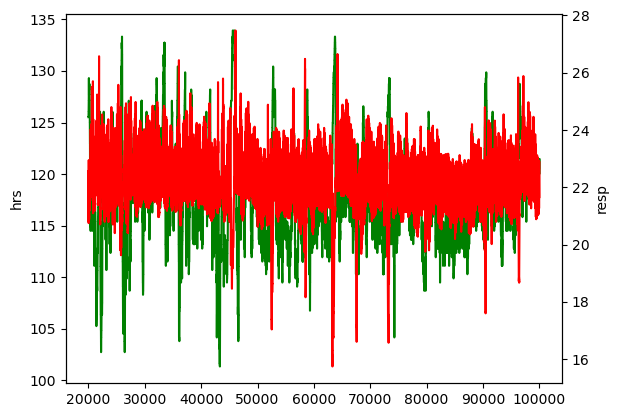

In [12]:
# plot 

sns.lineplot(data=df['hrs'], color="g")
# sns.lineplot(data=df['resp'], color="r")
ax2 = plt.twinx()
# sns.lineplot(data=df['sig'], color="b", ax=ax2)
sns.lineplot(data=df['resp'], color="r", ax=ax2)

In [13]:
s = pd.Series(range(1, df['id'].nunique()+1))
dfy = pd.DataFrame({'id': s})
dfy = pd.merge(dfy, df[['hrs', 'id']], on="id", how='outer')
dfy = dfy.drop_duplicates()

# shift 1 row
dfy.loc[:, 'hrs'] = dfy.hrs.shift(-1)
dfy = dfy.dropna()

dfy

id         hrs
0         1  126.050420
11        2  127.118645
34        3  129.310350
57        4  127.659580
81        5  128.205120
...     ...         ...
79391  2754  119.521910
79416  2755  120.481926
79441  2756  121.457490
79515  2757  120.000000
79540  2758  121.457490

[2758 rows x 2 columns]

In [27]:
%matplotlib inline

import matplotlib.pylab as plt

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

extraction_settings = ComprehensiveFCParameters()

extracted_features = extract_features(df[['id', 'time', 'resp']], column_id='id', column_sort='time',
                     default_fc_parameters=extraction_settings,
                     # we impute = remove all NaN features automatically
                     impute_function=impute)



Feature Extraction: 100%|██████████| 30/30 [00:35<00:00,  1.20s/it]


In [32]:
filtered_features = select_features(extracted_features[:-1], dfy['hrs'].values)
filtered_features.to_csv(data_dir+'\\processed\\tsfeatures.csv', index=False)

In [26]:
# features_filtered = select_features(extracted_features[:-1], dfy['hrs'].values)
# features_filtered


from tsfresh.feature_selection.relevance import calculate_relevance_table
relevance_table = calculate_relevance_table(extracted_features[:-1].values, dfy['hrs'].values)


AttributeError: 'numpy.ndarray' object has no attribute 'sort_index'

In [ ]:
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
  
# Load the data
# dataset = dfr
# # drop = ['hrs', 'sig_min', 'sig_mean', 'sig_max' ]
# y_col = ['hrs']
# X, y =  dataset.drop(columns=y_col), dataset[y_col]

X, y = dfx[:-1], dfy['hrs']
  
# Splitting
train_X, test_X, train_y, test_y = train_test_split(X, y,
                      test_size = 0.3, random_state = 123)

# set objective
# obj = 'reg:linear' # deprecated, change to squarederror
obj = 'reg:squarederror'
# obj = 'reg:pseudohubererror'
  
# Instantiation
xgb_r = xg.XGBRegressor(objective = obj,
                  n_estimators = 1000, seed = 123)
  
# Fitting the model
xgb_r.fit(train_X, train_y)
  
# Predict the model
pred = xgb_r.predict(test_X)
  
# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))

# r2square compution
r2 = r2_score(test_y, pred)
print("R2 : % f" %(r2))

c:\Users\hafiidz\anaconda3\envs\boost\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


RMSE :  3.309499
R2 :  0.826285


In [ ]:
dft = pd.DataFrame({'y_actual':test_y, 'y_pred': pred})

sns.regplot(data=dft, x='y_actual', y='y_pred')


<AxesSubplot:xlabel='y_actual', ylabel='y_pred'>

In [ ]:
# df_csv = pd.read_csv(data_dir+'\processed\subsampled{postfix}.csv'.format(postfix='_'+filenames[2]))

# filter data both rows & columns
df2 = df_csv[1700000:2000000]
df2 = df2[['hrs', 'resp']]

# add time from index
df2['time'] = df2.index

# add unique id everytime hrs change
df2['id'] = (df2[['hrs']].diff() != 0).cumsum()

# print descriptions of the df
describe_df(df2)


dfx2 = extract_features(df2[['id', 'time', 'resp']], column_id='id', column_sort='time',
                     default_fc_parameters=extraction_settings,
                     # we impute = remove all NaN features automatically
                     impute_function=impute)

s2 = pd.Series(range(1, dfx2.shape[0]+1))
dfy2 = pd.DataFrame({'id': s2})
dfy2 = pd.merge(dfy2, df2[['hrs', 'id']], on="id", how='outer')
dfy2 = dfy2.drop_duplicates()


# shift 1 row
dfy2.loc[:, 'hrs'] = dfy2.hrs.shift(-1)
dfy2 = dfy2.dropna()

dfy2

                 hrs         resp           time           id
count         100000       100000         100000       100000
mean      122.481856    22.146614  549999.500000  1785.158420
std         9.420089     1.001889   28867.657797  1009.572313
min        63.157894     8.235697  500000.000000     1.000000
25%       117.647060    21.827144  524999.750000   908.000000
50%       121.457490    22.085403  549999.500000  1787.000000
75%       125.523010    22.432309  574999.250000  2657.000000
max       214.285720    31.064470  599999.000000  3544.000000
nunique   132.000000  3621.000000  100000.000000  3544.000000
count_na    0.000000     0.000000       0.000000     0.000000


Feature Extraction: 100%|██████████| 30/30 [00:56<00:00,  1.88s/it]


id        hrs
0         1  136.98630
23        2  136.36363
45        3  135.13513
67        4  137.61469
89        5  136.36363
...     ...        ...
99860  3539  130.43478
99883  3540  129.87013
99929  3541  132.74336
99952  3542  131.00436
99975  3543  131.57895

[3543 rows x 2 columns]

<AxesSubplot:ylabel='resp'>

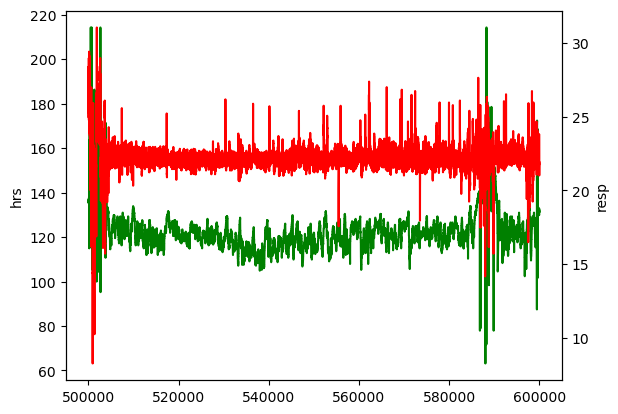

In [ ]:
# plot 

sns.lineplot(data=df2['hrs'], color="g")
# sns.lineplot(data=df['resp'], color="r")
ax2 = plt.twinx()
# sns.lineplot(data=df['sig'], color="b", ax=ax2)
sns.lineplot(data=df2['resp'], color="r", ax=ax2)

RMSE :  3.309499
R2 :  0.161869


<AxesSubplot:xlabel='y_actual', ylabel='y_pred'>

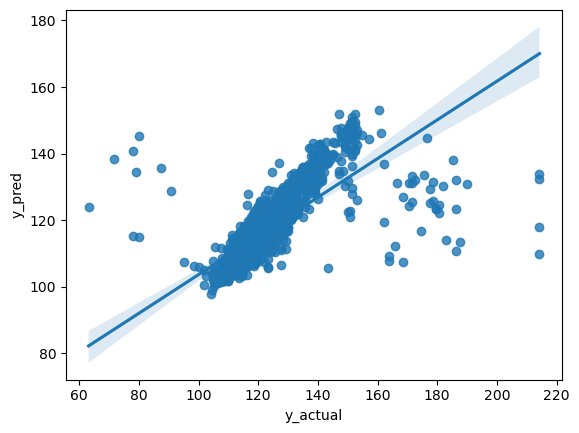

In [ ]:
blind_X, blind_y = dfx2[:-1], dfy2['hrs']

# Predict the model
blind_pred = xgb_r.predict(blind_X)
  
# RMSE Computation
blind_rmse = np.sqrt(MSE(blind_y, blind_pred))
print("RMSE : % f" %(rmse))

# r2square compution
blind_r2 = r2_score(blind_y, blind_pred)
print("R2 : % f" %(blind_r2))


dft = pd.DataFrame({'y_actual':blind_y, 'y_pred': blind_pred})

sns.regplot(data=dft, x='y_actual', y='y_pred')

In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score


# Initialize data
X, y = dfx[:-1], dfy['hrs']
  
# Splitting
train_X, test_X, train_y, test_y = train_test_split(X, y,
                      test_size = 0.3, random_state = 123)


# Initialize CatBoostRegressor
cat = CatBoostRegressor(iterations=20,
                          learning_rate=1,
                          depth=14)
 
# Fitting the model
cat.fit(train_X, train_y)
  
# Predict the model
pred = cat.predict(test_X)
  
# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))

# r2square compution
r2 = r2_score(test_y, pred)
print("R2 : % f" %(r2))

c:\Users\hafiidz\anaconda3\envs\boost\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


0:	learn: 3.6295591	total: 17.6s	remaining: 5m 34s
1:	learn: 3.0842651	total: 39.3s	remaining: 5m 53s
2:	learn: 2.7203688	total: 56.4s	remaining: 5m 19s
3:	learn: 2.4106973	total: 1m 13s	remaining: 4m 54s
4:	learn: 2.2862081	total: 1m 28s	remaining: 4m 25s
5:	learn: 2.1710250	total: 1m 43s	remaining: 4m 1s
6:	learn: 2.1213220	total: 1m 58s	remaining: 3m 40s
7:	learn: 2.1002942	total: 2m 16s	remaining: 3m 24s
8:	learn: 1.9473038	total: 2m 33s	remaining: 3m 8s
9:	learn: 1.9391997	total: 2m 52s	remaining: 2m 52s
10:	learn: 1.8534359	total: 3m 8s	remaining: 2m 34s
11:	learn: 1.7534953	total: 3m 26s	remaining: 2m 17s
12:	learn: 1.6899888	total: 3m 49s	remaining: 2m 3s
13:	learn: 1.5688770	total: 4m 12s	remaining: 1m 48s
14:	learn: 1.4674886	total: 4m 28s	remaining: 1m 29s
15:	learn: 1.3787253	total: 4m 44s	remaining: 1m 11s
16:	learn: 1.3643163	total: 4m 59s	remaining: 52.9s
17:	learn: 1.2559339	total: 5m 15s	remaining: 35s
18:	learn: 1.1755079	total: 5m 29s	remaining: 17.4s
19:	learn: 1.16

In [ ]:
dft = pd.DataFrame({'y_actual':test_y, 'y_pred': pred})

sns.regplot(data=dft, x='y_actual', y='y_pred')

<AxesSubplot:xlabel='y_actual', ylabel='y_pred'>

In [ ]:
blind_X, blind_y = dfx2[:-1], dfy2['hrs']

# Predict the model
blind_pred = cat.predict(blind_X)
  
# RMSE Computation
blind_rmse = np.sqrt(MSE(blind_y, blind_pred))
print("RMSE : % f" %(rmse))

# r2square compution
blind_r2 = r2_score(blind_y, blind_pred)
print("R2 : % f" %(blind_r2))


dft = pd.DataFrame({'y_actual':blind_y, 'y_pred': blind_pred})

sns.regplot(data=dft, x='y_actual', y='y_pred')

c:\Users\hafiidz\anaconda3\envs\boost\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


RMSE :  3.757785
R2 :  0.540544


<AxesSubplot:xlabel='y_actual', ylabel='y_pred'>